# Text generation with deep learning

In [1]:
import sys
import os
import os.path
import random
import collections
import shutil
import time
import glob
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import pi
import scipy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

**Задача**

   Обучить character recurrent neural network (char RNN) на датасете статей arxiv, а также на своих данных и исследовать её свойства.

Определим структуру сети, в качестве основного блока используем **GRU**

In [2]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

    def save_model(model, filename='rnn.ckpt'):
        checkpoint = {'input_size': model.input_size,
                      'hidden_size': model.hidden_size,
                      'output_size': model.output_size,
                      'n_layers': model.n_layers,
                      'state_dict': model.state_dict()}
        with open(filename, 'wb') as f:
            torch.save(checkpoint, f)

    def load_model(filename):

        with open(filename, 'rb') as f:
            checkpoint = torch.load(f)

        model = RNN(input_size = checkpoint['input_size'], 
                    output_size = checkpoint['output_size'], 
                    hidden_size=checkpoint['hidden_size'], 
                    n_layers=checkpoint['n_layers'])
        model.load_state_dict(checkpoint['state_dict'])

        return model

# Пример реализации класса для получения данных из датасета

In [3]:
class TextDataset(Dataset):
    def __init__(self, text, chunk_len=10, chunks_number=100):
        self.chunks_number = chunks_number
        self.chunk_len = chunk_len
        self.text = text
        self.all_symbols = list({x for x in self.text})

    def __len__(self):
        return self.chunks_number

    def _get_tensor(self, text):
        return torch.LongTensor(list(map(self.all_symbols.index, text))).cuda()

    def _decode_vector(self, text):
        text = text.view(-1).cpu().numpy()
        if text.shape[0] == 1:
            text = list(text)
        return ''.join([self.all_symbols[x] for x in text])

    def _get_random_slice(self):
        start_index = random.randint(0, len(self.text) - self.chunk_len)
        end_index = start_index + self.chunk_len + 1
        return self.text[start_index:end_index]

    def __getitem__(self, idx):
        chunk = self._get_random_slice()
        return self._get_tensor(chunk[:-1]), self._get_tensor(chunk[1:])

# Здесь должен быть код для считывания данных и создания даталоадера

In [ ]:
csv_path = 'data/arxiv.csv'  # Replace with your CSV path
summary_column = 'summary'  # Replace with your actual column name

df = pd.read_csv(csv_path)
text = ' '.join(df[summary_column].dropna().values)  # Combine all summaries into one string

chunk_len = 100  # Length of each training chunk
chunks_number = 100  # Number of chunks per epoch

arxiv_dataset = TextDataset(text, chunk_len=chunk_len, chunks_number=chunks_number)
loader = DataLoader(arxiv_dataset, batch_size=1, shuffle=True)

Смотрим, сколько уникальных символов есть в датасете - это и будет размер выходного вектора у нейронной сети

In [40]:
unique_symbols = len(arxiv_dataset.all_symbols)
n_layers = 2
hidden_size = 100

In [41]:
unique_symbols

97

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = RNN(unique_symbols, hidden_size, unique_symbols, n_layers)
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Здесь нужно реализовать функцию для генерации текста с помощью сети

In [34]:
def generate(net, device, dataset, prime_str='A', predict_len=100, temperature=0.8):
    net.eval()

    hidden = net.init_hidden().to(device)
    prime_input = dataset._get_tensor(prime_str)
    predicted_string = prime_str

    # Process the prime string
    for p in range(len(prime_input) - 1):
        _, hidden = net(prime_input[p], hidden)
    
    input_char = prime_input[-1]
    for _ in range(predict_len):
        output, hidden = net(input_char, hidden)
        output_dist = output.div(temperature).exp().cpu()
        top_i = torch.multinomial(output_dist, 1).item()
        predicted_char = dataset.all_symbols[top_i]
        predicted_string += predicted_char
        input_char = torch.tensor([top_i], dtype=torch.long).to(device)
    
    net.train()
    return predicted_string

# Здесь должен быть цикл тренировки

In [ ]:
epochs = 1

In [ ]:
start_time = time.time()
from tqdm import tqdm

all_losses = []

torch.set_float32_matmul_precision("high")
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

for epoch in range(1, epochs+1):
    total_loss = 0
    for batch_idx, (inputs, targets) in tqdm(enumerate(loader), total=len(loader)):
        inputs = inputs.squeeze(0).to(device)
        targets = targets.squeeze(0).to(device)
        
        hidden = net.init_hidden().to(device)
        optimizer.zero_grad()
        loss = 0
        
        for t in range(inputs.size(0)):
            with torch.autocast(device_type="cuda"):
                output, hidden = net(inputs[t], hidden)
                loss += criterion(output, targets[t].unsqueeze(0))
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    all_losses.append(avg_loss)
    print(f'Epoch {epoch}, Avg Loss: {avg_loss:.4f}, Time: {time.time() - start_time:.2f}s')
    
    sample = generate(net, device, arxiv_dataset, prime_str='In this research ', temperature=0.8)
    print(f'Generated: {sample}\n')

print("Saving...")
RNN.save_model(net, "TrainedModel.ckpt")

  1%|          | 101/10000 [00:14<22:07,  7.45it/s] 

Epoch 1, Batch 100, Loss: 293.7578125


  2%|▏         | 201/10000 [00:27<21:57,  7.44it/s]

Epoch 1, Batch 200, Loss: 263.8544921875


  3%|▎         | 301/10000 [00:40<20:47,  7.77it/s]

Epoch 1, Batch 300, Loss: 262.4697265625


  4%|▍         | 401/10000 [00:54<21:13,  7.54it/s]  

Epoch 1, Batch 400, Loss: 284.50048828125


  5%|▌         | 501/10000 [01:08<20:32,  7.71it/s]

Epoch 1, Batch 500, Loss: 263.92529296875


  6%|▌         | 601/10000 [01:22<20:49,  7.52it/s]  

Epoch 1, Batch 600, Loss: 269.414794921875


  7%|▋         | 701/10000 [01:35<19:27,  7.97it/s]

Epoch 1, Batch 700, Loss: 356.5283203125


  8%|▊         | 801/10000 [01:48<20:12,  7.58it/s]

Epoch 1, Batch 800, Loss: 263.159912109375


  9%|▉         | 901/10000 [02:03<18:07,  8.37it/s]  

Epoch 1, Batch 900, Loss: 291.63623046875


 10%|█         | 1001/10000 [02:16<21:08,  7.09it/s]

Epoch 1, Batch 1000, Loss: 246.648681640625


 11%|█         | 1101/10000 [02:30<19:53,  7.46it/s]  

Epoch 1, Batch 1100, Loss: 280.6507568359375


 12%|█▏        | 1201/10000 [02:43<17:52,  8.21it/s]

Epoch 1, Batch 1200, Loss: 227.18505859375


 13%|█▎        | 1301/10000 [02:56<18:37,  7.78it/s]

Epoch 1, Batch 1300, Loss: 254.8974609375


 14%|█▍        | 1401/10000 [03:11<18:00,  7.96it/s]  

Epoch 1, Batch 1400, Loss: 215.739013671875


 15%|█▌        | 1501/10000 [03:23<19:18,  7.34it/s]

Epoch 1, Batch 1500, Loss: 251.127685546875


 16%|█▌        | 1601/10000 [03:38<18:07,  7.72it/s]  

Epoch 1, Batch 1600, Loss: 207.9696044921875


 17%|█▋        | 1701/10000 [03:51<19:08,  7.23it/s]

Epoch 1, Batch 1700, Loss: 223.7694091796875


 18%|█▊        | 1801/10000 [04:05<51:04,  2.68it/s]  

Epoch 1, Batch 1800, Loss: 242.6495361328125


 19%|█▉        | 1901/10000 [04:19<18:20,  7.36it/s]

Epoch 1, Batch 1900, Loss: 228.5177001953125


 20%|██        | 2001/10000 [04:32<17:11,  7.75it/s]

Epoch 1, Batch 2000, Loss: 239.54827880859375


 21%|██        | 2101/10000 [04:46<18:43,  7.03it/s]  

Epoch 1, Batch 2100, Loss: 199.90966796875


 22%|██▏       | 2201/10000 [04:59<19:54,  6.53it/s]

Epoch 1, Batch 2200, Loss: 264.8887939453125


 23%|██▎       | 2301/10000 [05:14<17:29,  7.33it/s]  

Epoch 1, Batch 2300, Loss: 231.2552490234375


 24%|██▍       | 2401/10000 [05:27<16:16,  7.78it/s]

Epoch 1, Batch 2400, Loss: 236.0465087890625


 25%|██▌       | 2501/10000 [05:41<18:52,  6.62it/s]

Epoch 1, Batch 2500, Loss: 231.6376953125


 26%|██▌       | 2601/10000 [05:56<16:23,  7.52it/s]  

Epoch 1, Batch 2600, Loss: 217.7191162109375


 27%|██▋       | 2701/10000 [06:10<16:15,  7.48it/s]

Epoch 1, Batch 2700, Loss: 236.94775390625


 28%|██▊       | 2801/10000 [06:25<16:23,  7.32it/s]  

Epoch 1, Batch 2800, Loss: 280.3004150390625


 29%|██▉       | 2901/10000 [06:38<15:32,  7.61it/s]

Epoch 1, Batch 2900, Loss: 224.83056640625


 30%|███       | 3001/10000 [06:53<20:51,  5.59it/s]

Epoch 1, Batch 3000, Loss: 226.730712890625


 31%|███       | 3101/10000 [07:07<15:19,  7.50it/s]

Epoch 1, Batch 3100, Loss: 258.1939697265625


 32%|███▏      | 3201/10000 [07:21<16:00,  7.08it/s]

Epoch 1, Batch 3200, Loss: 250.3375244140625


 33%|███▎      | 3301/10000 [07:36<15:06,  7.39it/s]

Epoch 1, Batch 3300, Loss: 209.4881591796875


 34%|███▍      | 3401/10000 [07:49<15:22,  7.15it/s]

Epoch 1, Batch 3400, Loss: 248.55242919921875


 35%|███▌      | 3501/10000 [08:05<17:35,  6.16it/s]

Epoch 1, Batch 3500, Loss: 192.2933349609375


 36%|███▌      | 3601/10000 [08:20<14:31,  7.35it/s]

Epoch 1, Batch 3600, Loss: 202.85736083984375


 37%|███▋      | 3701/10000 [08:35<14:13,  7.38it/s]

Epoch 1, Batch 3700, Loss: 212.0162353515625


 38%|███▊      | 3801/10000 [08:49<13:57,  7.40it/s]

Epoch 1, Batch 3800, Loss: 234.400146484375


 39%|███▉      | 3901/10000 [09:03<14:29,  7.01it/s]

Epoch 1, Batch 3900, Loss: 224.4637451171875


 40%|████      | 4001/10000 [09:18<13:21,  7.48it/s]

Epoch 1, Batch 4000, Loss: 230.9998779296875


 41%|████      | 4101/10000 [09:32<13:13,  7.43it/s]

Epoch 1, Batch 4100, Loss: 231.711669921875


 42%|████▏     | 4201/10000 [09:47<12:51,  7.51it/s]

Epoch 1, Batch 4200, Loss: 229.07421875


 43%|████▎     | 4301/10000 [10:00<13:09,  7.22it/s]

Epoch 1, Batch 4300, Loss: 195.9046630859375


 44%|████▍     | 4401/10000 [10:16<12:27,  7.49it/s]

Epoch 1, Batch 4400, Loss: 185.5882568359375


 45%|████▌     | 4501/10000 [10:29<12:33,  7.30it/s]

Epoch 1, Batch 4500, Loss: 185.6302490234375


 46%|████▌     | 4601/10000 [10:43<11:25,  7.88it/s]

Epoch 1, Batch 4600, Loss: 202.21533203125


 47%|████▋     | 4701/10000 [10:56<10:51,  8.13it/s]

Epoch 1, Batch 4700, Loss: 209.0543212890625


 48%|████▊     | 4801/10000 [11:09<11:39,  7.44it/s]

Epoch 1, Batch 4800, Loss: 217.091064453125


 49%|████▉     | 4901/10000 [11:23<10:57,  7.76it/s]

Epoch 1, Batch 4900, Loss: 200.92578125


 50%|█████     | 5001/10000 [11:36<10:46,  7.73it/s]

Epoch 1, Batch 5000, Loss: 183.6396484375


 51%|█████     | 5101/10000 [11:49<11:04,  7.37it/s]

Epoch 1, Batch 5100, Loss: 235.87603759765625


 52%|█████▏    | 5201/10000 [12:04<10:35,  7.55it/s]

Epoch 1, Batch 5200, Loss: 192.40008544921875


 53%|█████▎    | 5301/10000 [12:17<10:13,  7.66it/s]

Epoch 1, Batch 5300, Loss: 229.9981689453125


 54%|█████▍    | 5401/10000 [12:31<09:36,  7.98it/s]

Epoch 1, Batch 5400, Loss: 231.4481201171875


 55%|█████▌    | 5501/10000 [12:44<09:50,  7.62it/s]

Epoch 1, Batch 5500, Loss: 199.14569091796875


 56%|█████▌    | 5601/10000 [12:58<10:16,  7.13it/s]

Epoch 1, Batch 5600, Loss: 177.84698486328125


 57%|█████▋    | 5701/10000 [13:12<08:59,  7.96it/s]

Epoch 1, Batch 5700, Loss: 168.6552734375


 58%|█████▊    | 5801/10000 [13:25<09:14,  7.57it/s]

Epoch 1, Batch 5800, Loss: 239.569580078125


 59%|█████▉    | 5901/10000 [13:39<08:35,  7.96it/s]

Epoch 1, Batch 5900, Loss: 229.6923828125


 60%|██████    | 6001/10000 [13:53<08:51,  7.52it/s]

Epoch 1, Batch 6000, Loss: 175.8721923828125


 61%|██████    | 6101/10000 [14:07<09:28,  6.86it/s]

Epoch 1, Batch 6100, Loss: 184.081298828125


 62%|██████▏   | 6201/10000 [14:20<08:28,  7.47it/s]

Epoch 1, Batch 6200, Loss: 244.4544677734375


 63%|██████▎   | 6301/10000 [14:34<08:14,  7.48it/s]

Epoch 1, Batch 6300, Loss: 201.57177734375


 64%|██████▍   | 6401/10000 [14:49<07:58,  7.52it/s]

Epoch 1, Batch 6400, Loss: 198.83233642578125


 65%|██████▌   | 6501/10000 [15:02<07:51,  7.41it/s]

Epoch 1, Batch 6500, Loss: 219.6905517578125


 66%|██████▌   | 6601/10000 [15:16<07:19,  7.73it/s]

Epoch 1, Batch 6600, Loss: 188.12353515625


 67%|██████▋   | 6701/10000 [15:30<08:17,  6.63it/s]

Epoch 1, Batch 6700, Loss: 194.4892578125


 68%|██████▊   | 6801/10000 [15:43<07:16,  7.33it/s]

Epoch 1, Batch 6800, Loss: 222.53228759765625


 69%|██████▉   | 6901/10000 [15:58<06:26,  8.01it/s]

Epoch 1, Batch 6900, Loss: 215.30987548828125


 70%|███████   | 7001/10000 [16:11<06:39,  7.50it/s]

Epoch 1, Batch 7000, Loss: 166.4810791015625


 71%|███████   | 7101/10000 [16:26<06:37,  7.29it/s]

Epoch 1, Batch 7100, Loss: 207.5926513671875


 72%|███████▏  | 7201/10000 [16:39<06:00,  7.76it/s]

Epoch 1, Batch 7200, Loss: 198.21075439453125


 73%|███████▎  | 7301/10000 [16:52<05:42,  7.89it/s]

Epoch 1, Batch 7300, Loss: 186.84375


 74%|███████▍  | 7401/10000 [17:06<05:40,  7.64it/s]

Epoch 1, Batch 7400, Loss: 205.1163330078125


 75%|███████▌  | 7501/10000 [17:20<05:23,  7.74it/s]

Epoch 1, Batch 7500, Loss: 186.3023681640625


 76%|███████▌  | 7601/10000 [17:34<05:15,  7.60it/s]

Epoch 1, Batch 7600, Loss: 187.93112182617188


 77%|███████▋  | 7701/10000 [17:47<04:57,  7.72it/s]

Epoch 1, Batch 7700, Loss: 198.1375732421875


 78%|███████▊  | 7801/10000 [18:01<07:54,  4.64it/s]

Epoch 1, Batch 7800, Loss: 194.20465087890625


 79%|███████▉  | 7901/10000 [18:14<04:30,  7.76it/s]

Epoch 1, Batch 7900, Loss: 223.67486572265625


 80%|████████  | 8001/10000 [18:27<04:22,  7.62it/s]

Epoch 1, Batch 8000, Loss: 168.12841796875


 81%|████████  | 8101/10000 [18:42<04:07,  7.67it/s]

Epoch 1, Batch 8100, Loss: 182.37969970703125


 82%|████████▏ | 8201/10000 [18:55<03:50,  7.80it/s]

Epoch 1, Batch 8200, Loss: 188.5126953125


 83%|████████▎ | 8301/10000 [19:09<03:52,  7.32it/s]

Epoch 1, Batch 8300, Loss: 192.28909301757812


 84%|████████▍ | 8401/10000 [19:22<03:32,  7.53it/s]

Epoch 1, Batch 8400, Loss: 169.10519409179688


 85%|████████▌ | 8501/10000 [19:34<03:19,  7.51it/s]

Epoch 1, Batch 8500, Loss: 188.322021484375


 86%|████████▌ | 8601/10000 [19:49<02:58,  7.83it/s]

Epoch 1, Batch 8600, Loss: 215.445068359375


 87%|████████▋ | 8701/10000 [20:02<02:44,  7.87it/s]

Epoch 1, Batch 8700, Loss: 287.50579833984375


 88%|████████▊ | 8801/10000 [20:16<02:38,  7.55it/s]

Epoch 1, Batch 8800, Loss: 179.85256958007812


 89%|████████▉ | 8901/10000 [20:30<02:29,  7.34it/s]

Epoch 1, Batch 8900, Loss: 217.21826171875


 90%|█████████ | 9001/10000 [20:43<02:09,  7.71it/s]

Epoch 1, Batch 9000, Loss: 168.74468994140625


 91%|█████████ | 9101/10000 [20:57<01:55,  7.77it/s]

Epoch 1, Batch 9100, Loss: 211.74725341796875


 92%|█████████▏| 9201/10000 [21:10<01:45,  7.58it/s]

Epoch 1, Batch 9200, Loss: 231.49737548828125


 93%|█████████▎| 9301/10000 [21:24<01:32,  7.59it/s]

Epoch 1, Batch 9300, Loss: 167.6334228515625


 94%|█████████▍| 9401/10000 [21:38<01:19,  7.54it/s]

Epoch 1, Batch 9400, Loss: 185.81320190429688


 95%|█████████▌| 9501/10000 [21:51<01:07,  7.41it/s]

Epoch 1, Batch 9500, Loss: 207.71923828125


 96%|█████████▌| 9601/10000 [22:06<00:55,  7.25it/s]

Epoch 1, Batch 9600, Loss: 180.416259765625


 97%|█████████▋| 9701/10000 [22:19<00:40,  7.38it/s]

Epoch 1, Batch 9700, Loss: 171.42706298828125


 98%|█████████▊| 9801/10000 [22:34<00:26,  7.44it/s]

Epoch 1, Batch 9800, Loss: 176.09640502929688


 99%|█████████▉| 9901/10000 [22:47<00:13,  7.41it/s]

Epoch 1, Batch 9900, Loss: 182.34439086914062


100%|██████████| 10000/10000 [23:01<00:00,  7.24it/s]


Epoch 1, Batch 10000, Loss: 183.20559692382812
Epoch 1, Avg Loss: 218.0962, Time: 1381.76s
Generated: The is sulding besecring to the stats of redicolems
and trangner and stity the its preces of we fide st

Saving...


In [52]:
inputs[0]

tensor(29, device='cuda:0')

In [ ]:
net(inputs[0].type(torch.float16), hidden)[0].shape

In [ ]:
targets[0]

tensor(46, device='cuda:0')

In [61]:
all_losses

[218.0962288269043]

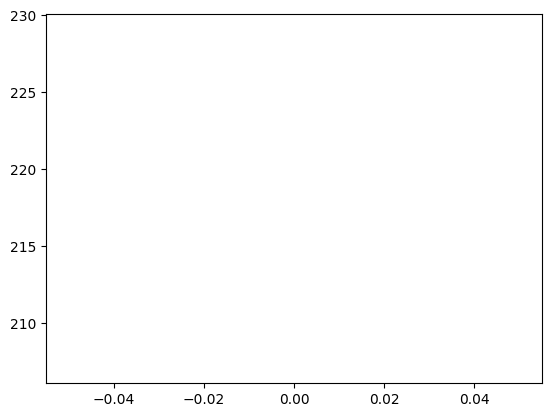

In [60]:
plt.figure()
plt.plot(all_losses)

## Результаты тренировки

In [59]:
print(generate(net, device, arxiv_dataset, 'In this research', 400), '\n')

In this research efficier is
comblic the of pystatialy. Is model with suctiaccolives. This the soted apprisical has a realso and
angores of-$p$ark and incalsod
live exparticaly instrom lach the fremul to a reserarnorithen of the resurturidis deverimations efformal mocture and compousuarence GF the decontems as.
The a for can an gse betwer amplodel ablic of repences recondems
resulting trable boiltely of and a gra 



# Здесь должны быть эксперименты с архитектурой и параметрами сети

# Здесь будет работа с вашими датасетами (которые вы захотите использовать)